In [1]:
import cv2 as cv 
import matplotlib.pyplot as mat
import hashlib

In [2]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb") ##weights

In [3]:
inWidth = 368
inHeight = 368
thr = 0.2

In [4]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [5]:
img = cv.imread("pose.jpg")

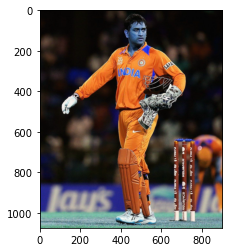

In [6]:
mat.imshow(img)

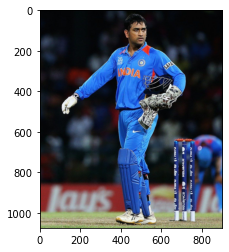

In [7]:
mat.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [8]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    return frame

In [9]:
estimated_image = pose_estimation(img)

In [10]:
cap = cv.VideoCapture('correct.mp4')
cap.set(3,800)
cap.set(4,800)

if not cap.isOpened():
    cap= cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open Video")
    
while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('Pose estimation', frame)
    
    for i in range(0, len(points)):
        print(points[i]) 
    
    

None
(162, 194)
(181, 194)
(194, 222)
(194, 264)
(144, 194)
(194, 222)
(194, 264)
(144, 264)
(137, 320)
(137, 361)
(162, 264)
(162, 320)
(150, 361)
None
None
(169, 180)
(150, 180)
(262, 626)
None
(169, 194)
(187, 194)
(200, 222)
(212, 264)
(150, 194)
(131, 222)
None
(175, 264)
(175, 320)
(144, 375)
(150, 264)
(144, 320)
(156, 361)
None
None
(175, 166)
(156, 166)
(262, 626)
None
(169, 194)
(187, 194)
(200, 222)
(212, 264)
(150, 194)
(131, 222)
None
(175, 264)
(169, 320)
(144, 375)
(150, 264)
(144, 320)
(156, 361)
None
None
(175, 166)
(156, 166)
(262, 626)
None
(169, 194)
(181, 194)
None
None
(150, 194)
None
None
(150, 264)
(144, 306)
(137, 375)
(175, 264)
(175, 320)
(169, 361)
None
None
None
(156, 166)
(37, 0)
None
(169, 180)
None
None
None
(150, 194)
None
None
(150, 264)
(144, 320)
(137, 375)
(175, 264)
(175, 320)
(169, 361)
None
None
None
None
(37, 0)
None
(169, 180)
None
None
None
None
None
None
(150, 250)
(137, 306)
(137, 361)
(175, 250)
(181, 306)
(175, 361)
None
None
None
None
(50

None
(156, 222)
(181, 222)
None
None
(144, 222)
(125, 236)
(118, 278)
(137, 292)
(137, 333)
(137, 389)
(162, 292)
(162, 347)
(156, 389)
None
None
(162, 194)
(150, 194)
(275, 13)
None
(156, 222)
(181, 222)
(187, 264)
(187, 292)
(144, 222)
(125, 236)
(118, 278)
(169, 292)
(137, 333)
(137, 389)
(144, 292)
(162, 347)
(156, 389)
None
None
(169, 194)
(150, 194)
(275, 13)
None
(156, 222)
(181, 222)
(194, 264)
(194, 292)
(144, 222)
(131, 250)
(118, 292)
(169, 292)
(162, 347)
(137, 389)
(144, 292)
(162, 347)
None
None
None
(162, 194)
(150, 194)
(275, 13)
None
(156, 222)
(175, 222)
None
None
(144, 222)
(125, 236)
(112, 278)
(162, 292)
(137, 320)
(137, 389)
(144, 278)
None
(150, 389)
None
None
(162, 194)
(150, 194)
(275, 13)
None
(156, 222)
(175, 222)
None
None
(144, 222)
(125, 236)
(112, 264)
(137, 292)
(137, 320)
(137, 389)
(162, 292)
(162, 333)
(156, 389)
None
None
None
(150, 194)
(275, 13)
None
(162, 194)
(175, 194)
None
None
(150, 166)
(125, 194)
None
(137, 278)
(137, 320)
(131, 389)
(162, 2

None
(156, 194)
None
None
None
None
None
None
(144, 264)
(187, 250)
(112, 375)
(162, 278)
(187, 333)
(181, 375)
None
None
None
None
(275, 13)
None
(156, 194)
None
None
None
(144, 194)
None
None
(144, 264)
(131, 320)
(125, 375)
(162, 264)
(175, 320)
(175, 375)
None
None
None
(150, 166)
(275, 13)
None
(156, 180)
None
None
None
(144, 194)
None
None
(144, 264)
(131, 320)
(131, 375)
(162, 264)
(175, 320)
(175, 375)
None
None
None
(150, 166)
(275, 13)
None
(156, 208)
(181, 208)
None
None
(137, 208)
(125, 236)
(112, 264)
(169, 278)
(137, 333)
(137, 375)
(144, 278)
(169, 333)
(162, 375)
None
None
(162, 180)
(150, 180)
(275, 13)
None
(156, 222)
(181, 222)
(194, 250)
(187, 292)
(137, 222)
(125, 250)
(125, 292)
(137, 292)
(137, 347)
(144, 389)
(144, 292)
(162, 347)
None
None
None
(169, 194)
(150, 194)
(275, 13)
None
(156, 222)
(181, 222)
(194, 250)
(187, 292)
(137, 222)
(125, 250)
(125, 292)
(169, 292)
(137, 347)
(137, 389)
(144, 292)
(162, 347)
(156, 375)
None
None
(162, 194)
(150, 194)
(275, 13

None
(156, 194)
None
None
None
None
None
None
(144, 278)
None
None
(162, 278)
(187, 333)
(187, 389)
None
None
None
None
(275, 13)
None
(156, 194)
None
None
None
None
None
None
(144, 278)
None
(118, 375)
(162, 278)
(187, 333)
(187, 389)
None
None
None
None
(275, 13)
None
(156, 180)
(169, 194)
None
None
(150, 180)
None
None
(144, 264)
(131, 320)
(125, 375)
(162, 264)
(181, 320)
(175, 389)
None
None
None
None
(275, 13)
None
(156, 180)
(169, 180)
None
None
(150, 180)
None
None
(144, 264)
(131, 320)
(125, 375)
(162, 264)
(181, 320)
(175, 389)
None
None
None
None
(275, 13)
None
(156, 194)
(169, 194)
None
None
(144, 194)
None
None
(144, 264)
(137, 320)
(131, 375)
(162, 264)
(175, 333)
(169, 389)
None
None
None
(150, 166)
(275, 13)
None
(150, 194)
None
None
None
None
None
None
(137, 278)
(131, 320)
(131, 389)
(156, 264)
(162, 333)
(156, 375)
None
None
None
None
(275, 13)
None
(150, 194)
None
None
None
None
None
None
(137, 278)
(131, 320)
(131, 389)
(156, 264)
(162, 333)
(156, 375)
None
None
No

In [14]:
cap = cv.VideoCapture(0)
cap.set(3,800)
cap.set(4,800)

if not cap.isOpened():
    cap= cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open Video")
    
while True:
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
    if cv.waitKey(1) & 0xFF == ord('q'): 
        break
        
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points1 = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points1.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points1[idFrom] and points1[idTo]:
            cv.line(frame, points1[idFrom], points1[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points1[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points1[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cap.release() 
    mat.show()
    cv.imshow('Pose estimation', frame)
    
    for i in range(0, len(points1)):
        print(points1[i]) 
    

(320, 135)
(306, 250)
(222, 260)
(180, 406)
None
(375, 250)
None
None
None
None
None
None
None
None
(292, 114)
(347, 114)
(264, 146)
(361, 125)
(612, 10)


In [16]:
comparison = points == points1 
equal_arrays = comparison
  
print(equal_arrays) 

False
